<a href="https://colab.research.google.com/github/mmilannaik/Interview-Prepartion-Data-Science/blob/master/hitachi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ATM Cash Dispense Forecasting Using XGBoost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [ ]:
# Load dataset
df = pd.read_excel("data_raw.xlsx", sheet_name=0)

In [ ]:
df.shape

(14593, 7)

In [ ]:
# Clean column names
df.columns = df.columns.str.strip().str.replace("'", "").str.replace(" ", "")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14593 entries, 0 to 14592
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Account        14593 non-null  object        
 1   ATMID          14593 non-null  object        
 2   caldate        14593 non-null  datetime64[ns]
 3   Dispense       14593 non-null  int64         
 4   DT             14593 non-null  int64         
 5   MaxCapacity    14593 non-null  int64         
 6   CountTotalTxn  14593 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 798.2+ KB


In [ ]:
# Convert types
df["ATMID"] = df["ATMID"].astype("category")
df["caldate"] = pd.to_datetime(df["caldate"])

# Time features
df["dayofweek"] = df["caldate"].dt.dayofweek
df["weekofyear"] = df["caldate"].dt.isocalendar().week
df["month"] = df["caldate"].dt.month

In [ ]:
# Create lag feature (previous day's dispense)
df = df.sort_values(by=["ATMID", "caldate"])
df["dispense_lag1"] = df.groupby("ATMID")["Dispense"].shift(1)


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/1201096629.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df["dispense_lag1"] = df.groupby("ATMID")["Dispense"].shift(1)


In [ ]:
# Select features and target
features = ["dispense_lag1", "DT", "CountTotalTxn", "dayofweek", "month"]
target = "Dispense"

In [ ]:
# Drop initial NaNs
df_model = df.dropna(subset=["dispense_lag1"]).copy()

# Split data: last 14 days for testing per ATM
def split_data(group):
    return group.iloc[:-14], group.iloc[-14:]

grouped = df_model.groupby("ATMID")
train_df = pd.concat([split_data(group)[0] for _, group in grouped])
test_df = pd.concat([split_data(group)[1] for _, group in grouped])


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/1383517793.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df_model.groupby("ATMID")


In [ ]:
import sklearn
print(sklearn.__version__)


1.3.2


In [ ]:
# Train XGBoost model
xgb = XGBRegressor(n_estimators=100, random_state=42)
xgb.fit(train_df[features], train_df[target])

# Predict on test set
test_df["prediction"] = xgb.predict(test_df[features])
mae = mean_absolute_error(test_df[target], test_df["prediction"])
mape = np.mean(np.abs((test_df[target] - test_df["prediction"]) / test_df[target])) * 100

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 95941.68
MAPE: inf%


# EDA

## Summary Stats

In [ ]:
# Summary statistics
summary_stats = df.describe()

# Missing values
missing_values = df.isnull().sum()

# Entry counts per ATM
atm_entry_counts = df["ATMID"].value_counts()

# Cash-out days (dispense = 0)
cash_out_counts = df[df["Dispense"] == 0]["ATMID"].value_counts()

# Average downtime per ATM
avg_downtime = df.groupby("ATMID")["DT"].mean().sort_values(ascending=False)


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/3447086357.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_downtime = df.groupby("ATMID")["DT"].mean().sort_values(ascending=False)


In [ ]:
from IPython.display import display

display(summary_stats)

,caldate,Dispense,DT,MaxCapacity,CountTotalTxn,dayofweek,weekofyear,month,dispense_lag1
count,14593,1.459300e+04,14593.000000,1.459300e+04,14593.000000,14593.000000,14593.0,14593.000000,1.457200e+04
mean,2022-02-24 13:07:26.762146304,4.027993e+05,158.538614,3.279753e+06,105.322963,2.999520,25.833687,6.349209,4.030326e+05
min,2021-01-01 00:00:00,0.000000e+00,0.000000,2.420000e+06,0.000000,0.000000,1.0,1.000000,0.000000e+00
25%,2021-08-28 00:00:00,1.685000e+05,0.000000,2.860000e+06,45.000000,1.000000,11.0,3.000000,1.687000e+05
50%,2022-03-07 00:00:00,3.653000e+05,0.000000,3.520000e+06,98.000000,3.000000,26.0,6.000000,3.655000e+05
75%,2022-09-02 00:00:00,5.780000e+05,64.000000,3.520000e+06,146.000000,5.000000,40.0,10.000000,5.780000e+05
max,2023-02-22 00:00:00,2.151800e+06,1440.000000,3.740000e+06,561.000000,6.000000,53.0,12.000000,2.151800e+06
std,NaN,3.036762e+05,356.073765,3.974770e+05,76.727151,2.001387,15.696886,3.597849,3.036832e+05


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/1933576944.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cash_out_top.index, y=cash_out_top.values, palette="Reds_r")


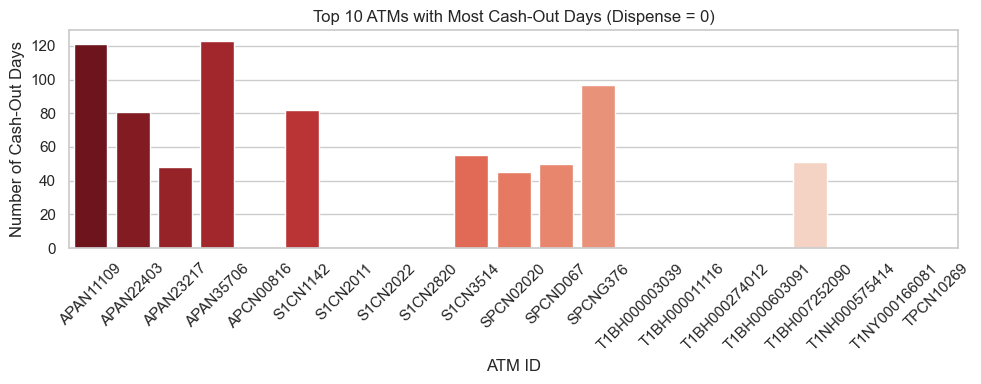

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# 1. Top ATMs by number of cash-out days
cash_out_top = df[df["Dispense"] == 0]["ATMID"].value_counts().head(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=cash_out_top.index, y=cash_out_top.values, palette="Reds_r")
plt.title("Top 10 ATMs with Most Cash-Out Days (Dispense = 0)")
plt.ylabel("Number of Cash-Out Days")
plt.xlabel("ATM ID")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

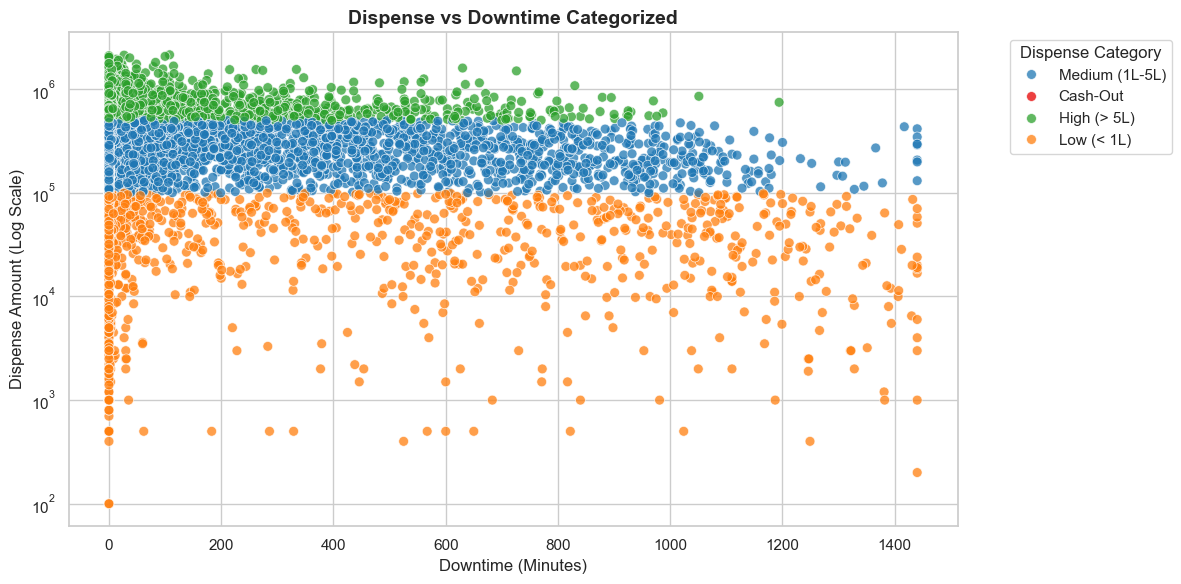

In [ ]:
# Categorize dispense levels
def categorize_dispense(amount):
    if amount == 0:
        return "Cash-Out"
    elif amount < 100000:
        return "Low (< 1L)"
    elif amount < 500000:
        return "Medium (1L-5L)"
    else:
        return "High (> 5L)"

custom_palette = {
    "Cash-Out": "#e60000",       # Bright red
    "Low (< 1L)": "#ff7f0e",         # Vivid orange
    "Medium (1L-5L)": "#1f77b4",    # Blue
    "High (> 5L)": "#2ca02c"         # Green
}


sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df,
    x="DT",
    y="Dispense",
    hue="DispenseCategory",
    palette=custom_palette,
    alpha=0.75,
    s=50  # marker size
)
plt.yscale("log")
plt.title("Dispense vs Downtime Categorized", fontsize=14, fontweight='bold')
plt.xlabel("Downtime (Minutes)", fontsize=12)
plt.ylabel("Dispense Amount (Log Scale)", fontsize=12)
plt.legend(title="Dispense Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()

## Avg Dispense in week

/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/976322275.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dow_avg, x="dayofweek", y="Dispense", palette="Blues_d")


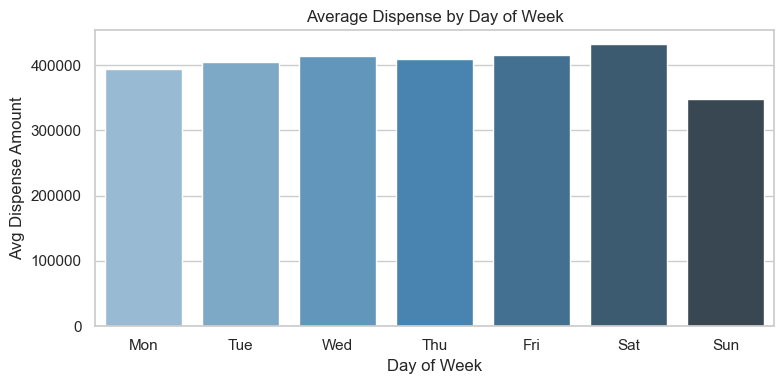

In [ ]:

dow_avg = df.groupby("dayofweek")["Dispense"].mean().reset_index()
dow_avg["dayofweek"] = dow_avg["dayofweek"].map({
    0: "Mon", 1: "Tue", 2: "Wed", 3: "Thu", 4: "Fri", 5: "Sat", 6: "Sun"
})

plt.figure(figsize=(8, 4))
sns.barplot(data=dow_avg, x="dayofweek", y="Dispense", palette="Blues_d")
plt.title("Average Dispense by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Dispense Amount")
plt.tight_layout()
plt.show()

## Avg utilization

In [ ]:
# Analyze average utilization per ATM (Dispense as % of Max Capacity)
# Attach bank info
atm_to_bank = df.drop_duplicates(subset=["ATMID"])[["ATMID", "Account"]]
# Calculate average utilization per ATM
df["Utilization"] = df["Dispense"] / df["MaxCapacity"]
atm_utilization = df.groupby("ATMID")["Utilization"].mean().reset_index()
atm_utilization["Utilization (%)"] = (atm_utilization["Utilization"] * 100).round(2)

# Join bank info
atm_utilization = pd.merge(atm_utilization, atm_to_bank, on="ATMID")
atm_utilization = atm_utilization.sort_values(by="Utilization (%)", ascending=False)



/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/3343667052.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  atm_utilization = df.groupby("ATMID")["Utilization"].mean().reset_index()


In [ ]:
display(atm_utilization)

,ATMID,Utilization,Utilization (%),Account
7,S1CN2022,0.234617,23.46,PQR
20,TPCN10269,0.196786,19.68,ABC
19,T1NY000166081,0.177882,17.79,XYZ
11,SPCND067,0.167658,16.77,PQR
1,APAN22403,0.165729,16.57,ABC
17,T1BH007252090,0.155015,15.50,XYZ
14,T1BH000011116,0.152482,15.25,XYZ
10,SPCN02020,0.152296,15.23,ABC
9,S1CN3514,0.134816,13.48,PQR
18,T1NH000575414,0.132731,13.27,XYZ


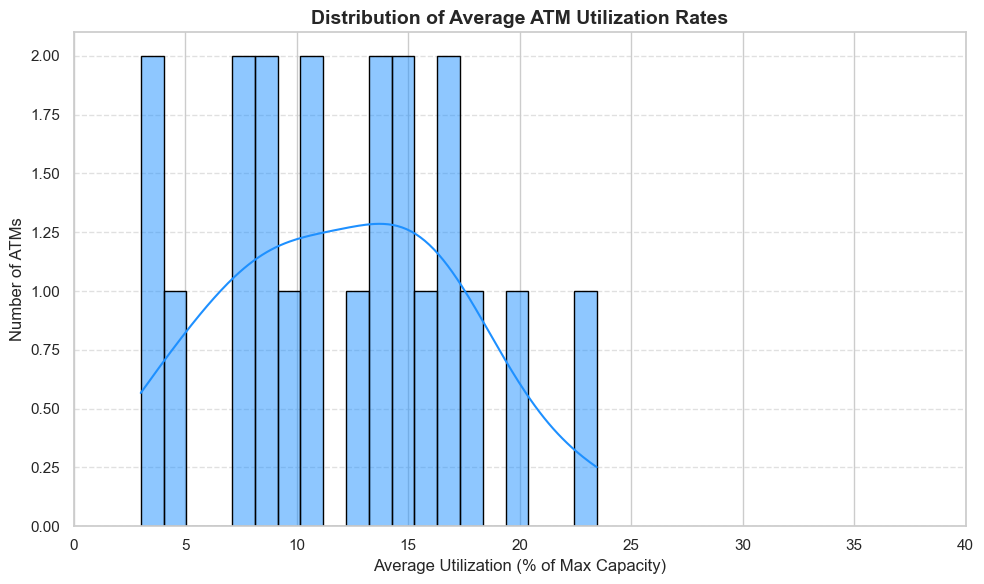

In [ ]:
# Refined histogram with narrower bins and adjusted range
plt.figure(figsize=(10, 6))
sns.histplot(
    atm_utilization["Utilization (%)"],
    bins=20,
    kde=True,
    color="dodgerblue",
    edgecolor="black"
)
plt.title("Distribution of Average ATM Utilization Rates", fontsize=14, weight="bold")
plt.xlabel("Average Utilization (% of Max Capacity)", fontsize=12)
plt.ylabel("Number of ATMs", fontsize=12)
plt.xlim(0, 40)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


# Model Train

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays

# --------------------------
# Load and preprocess data
# --------------------------

# Load your feature-engineered dataset
df = pd.read_csv("atm_forecast_feature_set_with_clusters.csv")
df["caldate"] = pd.to_datetime(df["caldate"])
df["Cluster"] = df["Cluster"].astype(int)

# Sort by ATM and date for time-based features
df = df.sort_values(by=["ATMID", "caldate"])

# --------------------------
# Feature Engineering
# --------------------------

# Lag features
df["Lag3"] = df.groupby("ATMID")["Dispense"].shift(3)
df["Lag7"] = df.groupby("ATMID")["Dispense"].shift(7)

# Holiday flag (India)
years = df["caldate"].dt.year.unique()
indian_holidays = holidays.India(years=years)
df["Holiday"] = df["caldate"].isin(indian_holidays) | df["caldate"].dt.weekday.isin([5, 6])
df["Holiday"] = df["Holiday"].astype(int)

# Drop rows with missing lags
df = df.dropna(subset=["Dispense_Lag1", "Lag3", "Lag7", "Rolling_7"])

# Optional: Filter out rows where target is 0 to avoid MAPE infinity
df = df[df["Dispense"] != 0]

# --------------------------
# Model Training
# --------------------------

# Define features and target
features = [
    "Dispense_Lag1", "Lag3", "Lag7", "Rolling_7",
    "DT", "CountTotalTxn", "dayofweek", "month",
    "Holiday", "CashOutFlag_yday", "UnderUtilized_yday", "Cluster"
]
target = "Dispense"

X = df[features]
y = df[target]

# Split (no shuffle to preserve time order)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

# Train XGBoost model
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# --------------------------
# Evaluation
# --------------------------

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("✅ XGBoost Model Performance with India Holidays + Lag Features:")
print(f"MAE: ₹{mae:.2f}")
print(f"RMSE: ₹{rmse:.2f}")
print(f"MAPE: {mape:.2f}%")


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/2833252870.py:31: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["Holiday"] = df["caldate"].isin(indian_holidays) | df["caldate"].dt.weekday.isin([5, 6])


✅ XGBoost Model Performance with India Holidays + Lag Features:
MAE: ₹156942.33
RMSE: ₹214453.78
MAPE: 64.71%


In [ ]:
df['Cluster'].unique()

array([1, 0, 2])

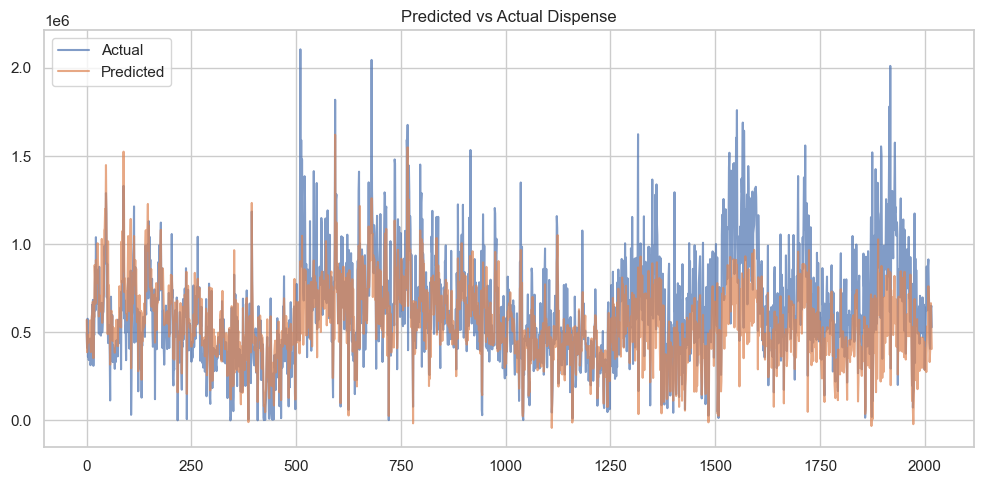

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("Predicted vs Actual Dispense")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Cluster-wise error analysis
X_test_with_results = X_test.copy()
X_test_with_results["Actual"] = y_test.values
X_test_with_results["Predicted"] = y_pred
X_test_with_results["Error"] = X_test_with_results["Predicted"] - X_test_with_results["Actual"]
X_test_with_results["AbsError"] = X_test_with_results["Error"].abs()
X_test_with_results["APE"] = np.abs((X_test_with_results["Actual"] - X_test_with_results["Predicted"]) / X_test_with_results["Actual"]) * 100

cluster_eval = X_test_with_results.groupby("Cluster").agg({
    "AbsError": "mean",
    "Error": lambda x: np.sqrt(np.mean(x**2)),
    "APE": "mean"
}).reset_index()

cluster_eval.columns = ["Cluster", "MAE", "RMSE", "MAPE (%)"]

In [ ]:
cluster_eval

,Cluster,MAE,RMSE,MAPE (%)
0,0,156942.330365,214453.777866,64.710408


## Cluster wise

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import holidays

# Load dataset
df = pd.read_csv("atm_forecast_feature_set_with_clusters.csv")
df["caldate"] = pd.to_datetime(df["caldate"])
df["Cluster"] = df["Cluster"].astype(int)

# Sort for lags
df = df.sort_values(by=["ATMID", "caldate"])

# Add lag3 and lag7
df["Lag3"] = df.groupby("ATMID")["Dispense"].shift(3)
df["Lag7"] = df.groupby("ATMID")["Dispense"].shift(7)

# Add India holiday feature
years = df["caldate"].dt.year.unique()
indian_holidays = holidays.India(years=years)
df["Holiday"] = df["caldate"].isin(indian_holidays) | df["caldate"].dt.weekday.isin([5, 6])
df["Holiday"] = df["Holiday"].astype(int)

# Drop rows with missing or zero target
df = df.dropna(subset=["Dispense_Lag1", "Lag3", "Lag7", "Rolling_7"])
df = df[df["Dispense"] != 0]

# Feature columns
feature_cols = [
    "Dispense_Lag1", "Lag3", "Lag7", "Rolling_7", "DT", "CountTotalTxn",
    "dayofweek", "month", "Holiday", "CashOutFlag_yday", "UnderUtilized_yday"
]

# For collecting results
results = []
# Set parameters based on cluster
params = {
    0: dict(n_estimators=200, max_depth=4, learning_rate=0.05, subsample=0.8),
    1: dict(n_estimators=300, max_depth=3, learning_rate=0.07, subsample=0.7),
    2: dict(n_estimators=50, max_depth=3, learning_rate=0.1, subsample=0.8),
}



# Loop over each cluster
for cluster_id in sorted(df["Cluster"].unique()):
    print(f"\n📦 Training XGBoost for Cluster {cluster_id}...")

    # Subset for cluster
    cluster_df = df[df["Cluster"] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = cluster_df["Dispense"]

    # Train-test split (no shuffle)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

    # Replace model creation line in your loop with:
    model = XGBRegressor(random_state=42, **params[cluster_id])
    model.fit(X_train, np.log1p(y_train))
    y_pred = np.expm1(model.predict(X_test))

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"✅ Cluster {cluster_id} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    # Save results
    results.append({
        "Cluster": cluster_id,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2)
    })

# Final summary table
results_df = pd.DataFrame(results)
print("\n📊 Cluster-wise Forecast Performance Summary:")
print(results_df)


/var/folders/y2/jfzxnv695076xlk76ftftj4r0000gn/T/ipykernel_65369/3274470209.py:23: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df["Holiday"] = df["caldate"].isin(indian_holidays) | df["caldate"].dt.weekday.isin([5, 6])



📦 Training XGBoost for Cluster 0...
✅ Cluster 0 - MAE: 212847.67, RMSE: 270690.56, MAPE: 31.10%

📦 Training XGBoost for Cluster 1...
✅ Cluster 1 - MAE: 70908.32, RMSE: 96984.64, MAPE: 68.66%

📦 Training XGBoost for Cluster 2...
✅ Cluster 2 - MAE: 67220.17, RMSE: 106061.56, MAPE: 60.37%

📊 Cluster-wise Forecast Performance Summary:
   Cluster        MAE       RMSE  MAPE (%)
0        0  212847.67  270690.56     31.10
1        1   70908.32   96984.64     68.66
2        2   67220.17  106061.56     60.37


In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# Define custom MAPE scorer
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4],
    'learning_rate': [0.03, 0.05, 0.07],
    'subsample': [0.7, 0.8, 1.0]
}

# Loop through clusters
results = []
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_df = df[df["Cluster"] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = cluster_df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

    # Use log1p transform
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=mape_scorer,
        cv=3,
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, np.log1p(y_train))
    best_model = grid_search.best_estimator_

    # Predict and reverse transform
    y_pred = np.expm1(best_model.predict(X_test))

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"✅ Cluster {cluster_id} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    results.append({
        "Cluster": cluster_id,
        "Best Params": grid_search.best_params_,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2)
    })

# Final result table
results_df = pd.DataFrame(results)
print("\n📊 Hyperparameter Tuning Summary:")
print(results_df)


Fitting 3 folds for each of 54 candidates, totalling 162 fits
✅ Cluster 0 - MAE: 220199.88, RMSE: 282885.07, MAPE: 31.94%
Fitting 3 folds for each of 54 candidates, totalling 162 fits
✅ Cluster 1 - MAE: 69392.31, RMSE: 95249.83, MAPE: 62.32%
Fitting 3 folds for each of 54 candidates, totalling 162 fits
✅ Cluster 2 - MAE: 67926.15, RMSE: 107809.19, MAPE: 60.76%

📊 Hyperparameter Tuning Summary:
   Cluster                                        Best Params        MAE  \
0        0  {'learning_rate': 0.03, 'max_depth': 3, 'n_est...  220199.88   
1        1  {'learning_rate': 0.03, 'max_depth': 4, 'n_est...   69392.31   
2        2  {'learning_rate': 0.05, 'max_depth': 3, 'n_est...   67926.15   

        RMSE  MAPE (%)  
0  282885.07     31.94  
1   95249.83     62.32  
2  107809.19     60.76  


In [ ]:
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
from scipy.stats import uniform, randint

# Define custom MAPE scorer
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Randomized hyperparameter search space
param_dist = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(3, 6),
    'learning_rate': uniform(0.01, 0.1),
    'subsample': uniform(0.6, 0.4)
}

# Loop through clusters
results = []
for cluster_id in sorted(df["Cluster"].unique()):
    cluster_df = df[df["Cluster"] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = cluster_df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=False)

    # Use log1p transform
    model = XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=20,
        scoring=mape_scorer,
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    random_search.fit(X_train, np.log1p(y_train))
    best_model = random_search.best_estimator_

    # Predict and reverse transform
    y_pred = np.expm1(best_model.predict(X_test))

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"✅ Cluster {cluster_id} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

    results.append({
        "Cluster": cluster_id,
        "Best Params": random_search.best_params_,
        "MAE": round(mae, 2),
        "RMSE": round(rmse, 2),
        "MAPE (%)": round(mape, 2)
    })

# Final result table
results_df = pd.DataFrame(results)
print("\n📊 Hyperparameter Tuning Summary:")
print(results_df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Cluster 0 - MAE: 220800.59, RMSE: 286514.70, MAPE: 32.32%
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Cluster 1 - MAE: 69441.05, RMSE: 95117.29, MAPE: 59.04%
Fitting 3 folds for each of 20 candidates, totalling 60 fits
✅ Cluster 2 - MAE: 75032.80, RMSE: 123921.44, MAPE: 62.08%

📊 Hyperparameter Tuning Summary:
   Cluster                                        Best Params        MAE  \
0        0  {'learning_rate': 0.012306242504141576, 'max_d...  220800.59   
1        1  {'learning_rate': 0.014666566321361544, 'max_d...   69441.05   
2        2  {'learning_rate': 0.015808361216819947, 'max_d...   75032.80   

        RMSE  MAPE (%)  
0  286514.70     32.32  
1   95117.29     59.04  
2  123921.44     62.08  
